## S5k example/demo notebook
Demo/example of the S5k module summing fast and slow ramps with individual amplitude control.

In [17]:
from spirack import SPI_rack, S5k_module, version
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

%matplotlib notebook

assert version.__version__ >= '0.1.4', 'spirack version needs to be >= 0.1.4'
print("SPI-rack Code Version: " + version.__version__)

SPI-rack Code Version: 0.1.4


Open SPI rack connection and unlock (necessary after bootup of the controller module).

In [306]:
spi = SPI_rack("COM4", 1000000, 1)
spi.unlock()

Create new S5k module object at correct address and set clock source to internal clock. The clock can be divided by all even numbers between 2-510.  

We'll set DAC 1-8 at 50 MHz and DAC 9-16 at 500 KHz. This allows us to play the same waveform on both, with a factor 100 time difference. All these settings are base on a 200 MHz internal oscillator.

In [554]:
s5k = S5k_module(spi, 2)
s5k.set_clock_source('internal')

In [555]:
for DAC in range(1,9):
    s5k.set_clock_division(DAC, 4)
for DAC in range(9, 17):
    s5k.set_clock_division(DAC, 400)

Set all the DACs to AWG mode. This allows us to write to the internal 4096k samples RAM.

In [556]:
for DAC in range(1, 17):
    s5k.set_waveform_mode(DAC, 'AWG')
    s5k.set_digital_gain(DAC, 0.2)

The ramp in both the slow and fast DAC's will be the same: 4000 samples long. To create the sawtooth we use the sawtooth function from the scipy signal library. The width argument allows us to define the width of the ramp as a fraction of the total waveform width: creates a ramp down.

<IPython.core.display.Javascript object>


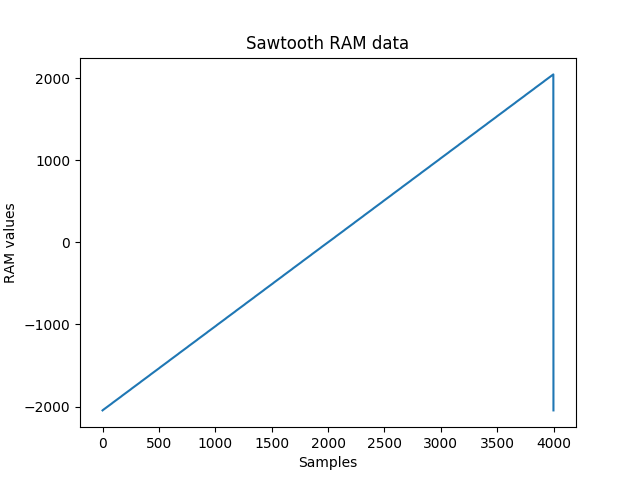

In [557]:
wv_len = 4000
max_val = 2047

width = 1

t = np.linspace(0, 1, 4000)
sawtooth = signal.sawtooth(2*np.pi*t, width) * max_val
sawtooth = sawtooth.astype(int)

plt.figure()
plt.plot(sawtooth)
plt.title('Sawtooth RAM data')
plt.xlabel('Samples')
plt.ylabel('RAM values')
plt.show()

We now have to upload the waveform to all DAC's. It only needs to be uploaded once to each DAC chip (each chip contains for DACs with shared memory). We will then simply point all the DAC's in the chip to use the same block of RAM.

In [558]:
s5k.upload_waveform(1, sawtooth, 0, set_pattern_length = True)
s5k.upload_waveform(5, sawtooth, 0, set_pattern_length = True)
s5k.upload_waveform(9, sawtooth, 0, set_pattern_length = True)
s5k.upload_waveform(13, sawtooth, 0, set_pattern_length = True)

for DAC in range(1,17):
    s5k.set_RAM_address(DAC, 0, len(sawtooth))

We also have to set the length of the trigger period. It runs on the slowest clock used in the system, in this case at 500kHz. The period length is equal to the slow sawtooth

In [559]:
s5k.set_pattern_length_trigger(len(sawtooth)-1)

One issue we now run into is the trigger delay. Each chip has a delay of 15 clock cycles from trigger in, to start outputting. This is especially noticable in this case where half is running at 500 kHz and the other half at 50 MHz. To compensate for this (to get them to start at the same time), we delay the start of the fast running DACs.

The delay is 15 clock cycles at 500 kHz. This gives a delay of 30 us. As the fast DACs are running at 50 MHz, we need to delay by 1500 clock cycles. We write this (minus 1) to the necessary DAC chips.

In [560]:
fast_period = 1/50e6
slow_period = 1/500e3

delay_necessary = 15*slow_period
delay_cycles = round(delay_necessary/fast_period)
delay_cycles = int(delay_cycles)

s5k.write_AD9106(s5k.DAreg.PATTERN_DLY, delay_cycles-1, 3)
s5k.write_AD9106(s5k.DAreg.PATTERN_DLY, delay_cycles-1, 1)

Now we can start the module, either by running from software or giving a gate on the front of the module.

In [561]:
s5k.run_module(True)

Set the gain of the slow ramp to 0.5x, and of the fast ramp to 0.1x. Gain can go to 2x, but both channels can max out the swing of the output at a gain of 1x.

In [562]:
for DAC in range(1, 9):
    s5k.set_digital_gain(DAC, 0.1)
for DAC in range(9, 17):
    s5k.set_digital_gain(DAC, 0.7)